In [177]:
from ortools.sat.python import cp_model
import collections
import json 

class SolutionPrinter(cp_model.CpSolverSolutionCallback):
    """Print intermediate solutions."""

    def __init__(self):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__solution_count = 0

    def on_solution_callback(self):
        """Called at each new solution."""
        print(
            "Solution %i, time = %f s, objective = %i"
            % (self.__solution_count, self.wall_time, self.objective_value)
        )
        self.__solution_count += 1


task_type = collections.namedtuple("task_type", "start end interval machine")


data = json.load(open("hayday_tasks.json"))
source_id = data["machine"]
machine_len = sum(len(source_id[machine_id]) for machine_id in source_id)
tasks = data["tasks"]

duration = {task['id']: task['duration'] for task in tasks}
horizon = sum(task['duration'] for task in tasks)
times = range(horizon)

model = cp_model.CpModel()

all_tasks = {}
intervals_per_resources = collections.defaultdict(list)

for task in tasks:
    start_var = model.new_int_var(0, horizon, 'start_%i' % task['id'])
    end_var = model.new_int_var(0, horizon, 'end_%i' % task['id'])
    interval_var = model.new_interval_var(start_var, duration[task['id']], end_var, 'interval_%i' % task['id'])
    machine_var = model.new_int_var_from_domain(cp_model.Domain.FromValues(task['machine']), 'machine_%i' % task['id'])
    all_tasks[task['id']] = task_type(
        start=start_var, end=end_var, interval=interval_var, machine=machine_var,
    )

    if len(task['machine']) == 1:
        intervals_per_resources[task['machine'][0]].append(interval_var)
    else:
        l_presences = []
        for machine_id in task['machine']:
            l_presence = model.new_bool_var('presence_%i_%i' % (task['id'], machine_id))
            l_start = model.new_int_var(0, horizon, 'start_%i_%i' % (task['id'], machine_id))
            l_end = model.new_int_var(0, horizon, 'end_%i_%i' % (task['id'], machine_id))   
            l_interval = model.new_optional_interval_var(l_start, duration[task['id']], l_end, l_presence, 'interval_%i_%i' % (task['id'], machine_id))
            l_presences.append(l_presence)

            model.add(start_var == l_start).only_enforce_if(l_presence)
            model.add(end_var == l_end).only_enforce_if(l_presence)
            model.add(machine_var == machine_id).only_enforce_if(l_presence)
            
            intervals_per_resources[machine_id].append(l_interval)
        model.add_exactly_one(l_presences)

for machine_id in range(1,machine_len+1):
    intervals = intervals_per_resources[machine_id]
    if len(intervals) > 1:
        model.add_no_overlap(intervals)

for task in tasks:
    for dependency in task['dependent']:
        model.Add(all_tasks[task['id']].start >= all_tasks[dependency].end)



obj_var = model.new_int_var(0, horizon, 'makespan')
model.add_max_equality(obj_var, [all_tasks[task['id']].end for task in tasks])
model.minimize(obj_var)

solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 300
solution_printer = SolutionPrinter()
status = solver.solve(model,solution_printer)
print()
print("solve status: %s" % solver.status_name(status))
print("Optimal objective value: %i" % solver.objective_value)
print("Statistics")
print("  - conflicts : %i" % solver.num_conflicts)
print("  - branches  : %i" % solver.num_branches)
print("  - wall time : %f s" % solver.wall_time)

Solution 0, time = 0.003583 s, objective = 3420
Solution 1, time = 0.005131 s, objective = 3120
Solution 2, time = 0.005917 s, objective = 3000

solve status: OPTIMAL
Optimal objective value: 3000
Statistics
  - conflicts : 0
  - branches  : 4
  - wall time : 0.016721 s


In [178]:
import pandas as pd
data = []
for task in tasks:
    task_id = task['id']
    task_name = task['name']
    start = solver.Value(all_tasks[task_id].start)
    end = solver.Value(all_tasks[task_id].end)
    machine = solver.Value(all_tasks[task_id].machine)
    job_id = task['job_id']
    # machine name = source_id + machine 
    # source name
    for source in source_id:
        if machine in source_id[source]:
            machine = source +'_'+ str(machine)
            break
    data.append([ task_name, start, end, machine, job_id])

df = pd.DataFrame(data, columns=[ "task_name", "start", "end", "machine", "job_id"])
df['job_id'] = df['job_id'].astype(str)

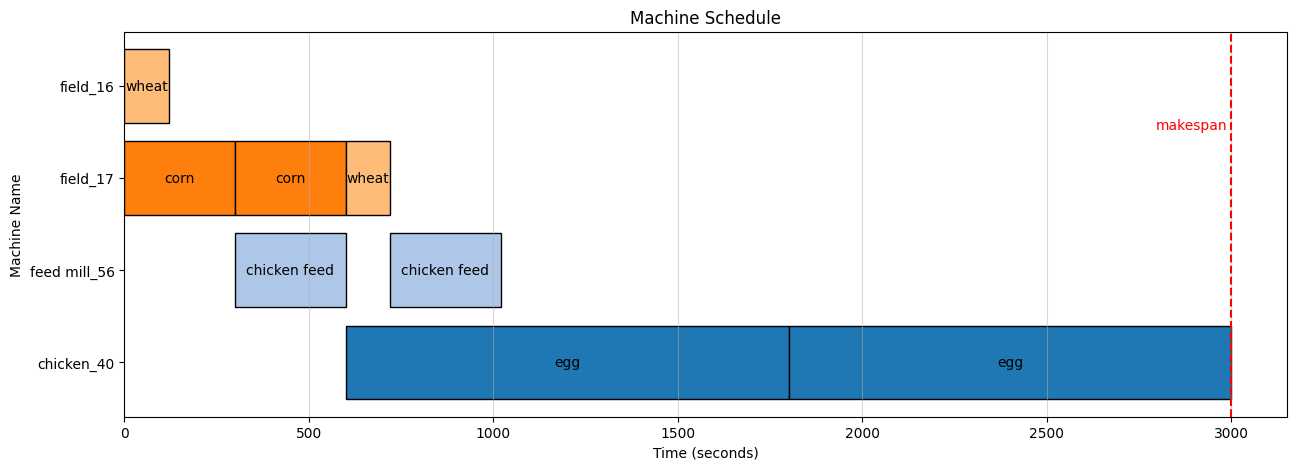

In [185]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
colors = plt.cm.tab20.colors
colors = {task_name: colors[i] for i, task_name in enumerate(df['task_name'].unique())}

for i, job_id in enumerate(df['job_id'].unique()):
    df_job = df[df['job_id'] == job_id]
    for i, row in df_job.iterrows():
        ax.barh(row['machine'], width=row['end']-row['start'], left=row['start'], 
                color=colors[row['task_name']],
                edgecolor='black',
                )
        ax.text(x=(row['start']+row['end'])/2, y=row['machine'],
                 s=row['task_name'], color='black',
                 verticalalignment='center', horizontalalignment='center',
                 
                 )
plt.title('Machine Schedule')
plt.xlabel('Time (seconds)')
plt.ylabel('Machine Name')
plt.yticks(df['machine'].unique())
ax.xaxis.grid(True, alpha=0.5)

ax.axvline(x=max(df['end']), color='r', linestyle='--')
ax.text(x=max(df['end'])-10, y=2.5, s='makespan', color='r', verticalalignment='bottom', horizontalalignment='right')

plt.show()
# export to image
fig.savefig('machine_schedule.png', bbox_inches='tight')

In [180]:
# df["start"] = pd.to_datetime(df["start"], unit="s")
# df["end"] = pd.to_datetime(df["end"], unit="s")

In [181]:
# import plotly.express as px
# import plotly

# chart1 = px.timeline(df, x_start="start", x_end="end", y="machine", color="job_id", title="Machine Schedule",
#                      text="task_name",
#                         category_orders={"machine": sorted(list(df["machine"].unique()))}
#                      )
# # hide date only show time
# chart1.update_xaxes(type='date', tickformat='%H:%M:%S')
# chart1.show()

# chart2 = px.timeline(df, x_start="start", x_end="end", y="job_id", color="machine", title="Job Schedule",
#                      text="task_name",
#                         category_orders={"job_id": sorted(list(df["job_id"].unique()))}
#                      )
# chart2.update_xaxes(type='date', tickformat='%H:%M:%S')
# chart2.show()